In [1]:
from ROOT import TMVA, TFile, TTree, TCut, TString
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Concatenate, Dense, LSTM, Input, concatenate, SimpleRNN, GRU, Masking, Lambda, Reshape, Dropout, RNN
from tensorflow.keras.optimizers import Adagrad, SGD, RMSprop, Adam
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree
from IPython.display import display
import graphviz
from numba import cuda
from array import array
import pickle
import scikitplot as skplt
import seaborn as sns

Welcome to JupyROOT 6.19/01


Load signal and background trees

In [2]:
signalFile=TFile.Open("samples/sig_nonres_bbww.root")
backgroundFile=TFile.Open("samples/bkg_ttbar_dilepton.root")

In [3]:
signalTree=signalFile.Get("ntup")
backgroundTree=backgroundFile.Get("ntup")

In [4]:
signalNum=signalTree.GetEntries()
backgroundNum=backgroundTree.GetEntries()
print("signal events number before cut is: ",signalNum)
print("background events number before cut is: ",backgroundNum)

signal events number before cut is:  84531
background events number before cut is:  10995


Convert minitree into numpy

In [5]:
signalArray=signalTree.AsMatrix(["weight","bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])
backgroundArray=backgroundTree.AsMatrix(["weight","bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])
print(signalArray.shape)

(84531, 22)


In [6]:
dataSignal=pd.DataFrame(data=signalArray[:,1:],columns=["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])

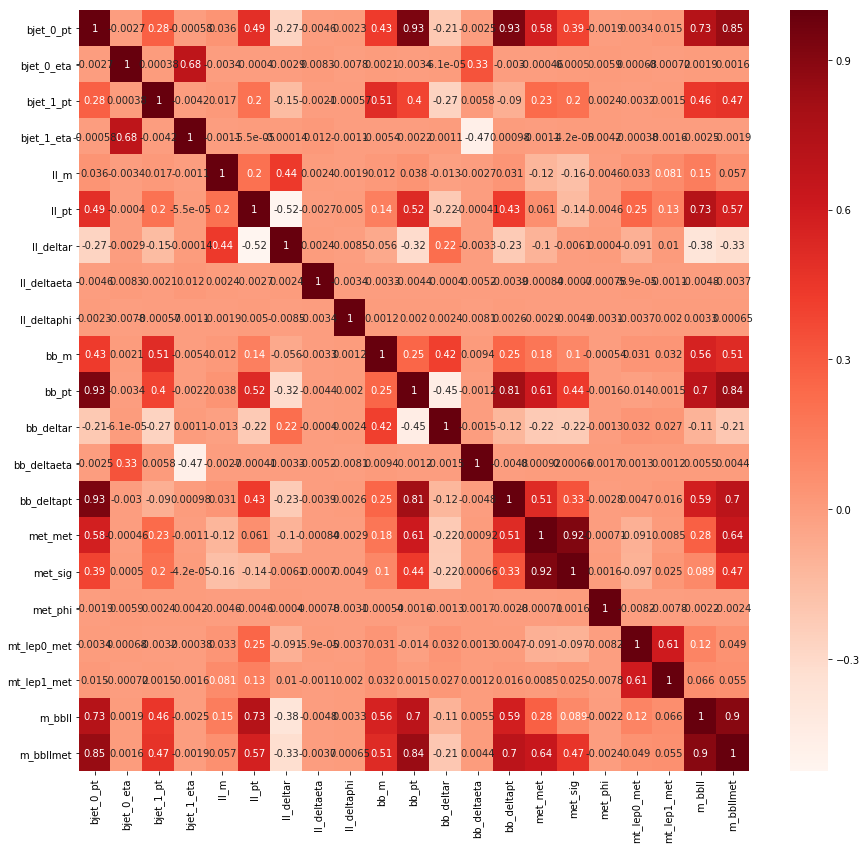

In [7]:
plt.figure(figsize=(15,14))
cor = dataSignal.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

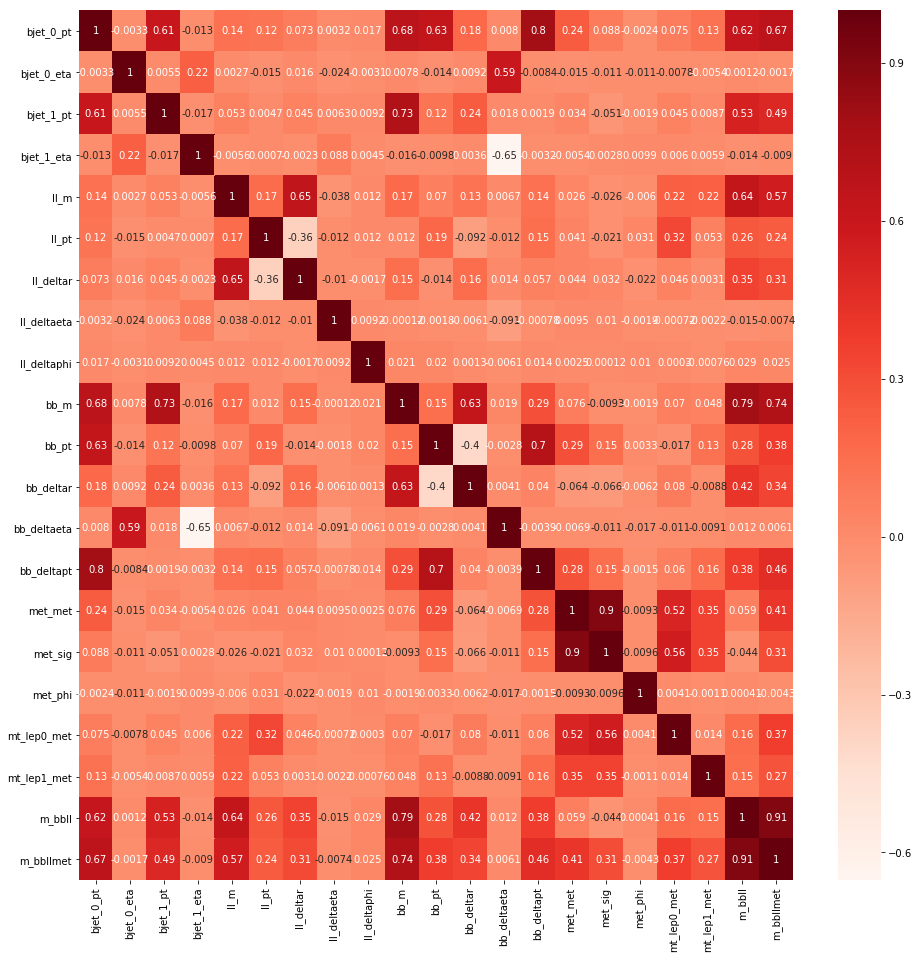

In [8]:
dataBackground=pd.DataFrame(data=backgroundArray[:,1:],columns=["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])
plt.figure(figsize=(16,16))
cor = dataBackground.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()



In [9]:
print(signalArray)

[[ 6.63798284e-06  1.93596594e+05  2.22759295e+00 ...  1.17032334e+04
   7.97536500e+05  9.38240125e+05]
 [ 3.08597753e-05  5.50776875e+04 -1.85068977e+00 ...  2.45457104e+03
   3.57337594e+05  3.80882156e+05]
 [ 9.18221331e-05  9.44623281e+04 -6.25142574e-01 ...  1.43974580e+04
   3.72064469e+05  4.70010094e+05]
 ...
 [-2.46308873e-05  2.64865438e+05 -3.38311642e-01 ...  2.45852188e+04
   6.20515250e+05  7.57952750e+05]
 [ 1.14938621e-05  1.80449469e+05 -1.26825857e+00 ...  2.02921816e+04
   6.34030875e+05  7.65080125e+05]
 [ 6.86499316e-06  1.76849109e+05 -2.05268168e+00 ...  5.30523867e+04
   4.77484812e+05  8.07346125e+05]]


In [10]:
print(signalArray[:,1])

[193596.59375   55077.6875    94462.328125 ... 264865.4375   180449.46875
 176849.109375]


Add signal Region cuts $m_{jj}>300$ Gev and $|\Delta(y_{jj})|>2.0$.

In [11]:
signalSample=signalArray#[(abs(signalArray[:,3])>2.0)&(signalArray[:,1]>300)]
backgroundSample=backgroundArray#[(abs(backgroundArray[:,3])>2.0)&(backgroundArray[:,1]>300)]

In [12]:
print(len(signalSample))
print(len(backgroundSample))

84531
10995


In [13]:
signalNum=len(signalSample)
backgroundNum=len(backgroundSample)
print("signal event number after cut is: ",signalNum)
print("background event number after cut is:",backgroundNum)

signal event number after cut is:  84531
background event number after cut is: 10995


Split datasets into training and testing subsets

In [14]:
trainingRatio=0.9
sigTrainNum=int(signalNum*0.9)
backgroundTrainNum=int(backgroundNum*0.9)
sigTestNum=signalNum-sigTrainNum
backgroundTestNum=backgroundNum-backgroundTrainNum
print("training signal events number is: ",sigTrainNum)
print("testing signal events number is: ",sigTestNum)
print("training background events number is: ",backgroundTrainNum)
print("testing background events number is: ",backgroundTestNum)


training signal events number is:  76077
testing signal events number is:  8454
training background events number is:  9895
testing background events number is:  1100


In [15]:
signal_row=np.arange(0,signalNum-1,1)
background_row=np.arange(0,backgroundNum-1,1)
signal_train_row=np.random.choice(signal_row,size=sigTrainNum,replace=False)
background_train_row=np.random.choice(background_row,size=backgroundTrainNum,replace=False)
label_signal_train=np.ones((sigTrainNum,1))
label_background_train=np.zeros((backgroundTrainNum,1))
label_signal_test=np.ones((sigTestNum,1))
label_background_test=np.zeros((backgroundTestNum,1))
signalTrain=signalSample[signal_train_row,:]
signalTest=np.delete(signalSample,signal_train_row,axis=0)
backgroundTrain=backgroundSample[background_train_row,:]
backgroundTest=np.delete(backgroundSample,background_train_row,axis=0)
signalTrain=np.concatenate((label_signal_train,signalTrain),axis=1)
backgroundTrain=np.concatenate((label_background_train,backgroundTrain),axis=1)
signalTest=np.concatenate((label_signal_test,signalTest),axis=1)
backgroundTest=np.concatenate((label_background_test,backgroundTest),axis=1)
ratio=sum(signalTrain[:,1])/sum(backgroundTrain[:,1])
signalTrain[:,1]=signalTrain[:,1]/ratio
print(backgroundTest)
print(ratio)

[[0.00000000e+00 2.96300581e-02 1.00949195e+05 ... 1.08738836e+05
  3.06538438e+05 5.22997188e+05]
 [0.00000000e+00 2.64660138e-02 7.59660781e+04 ... 3.84058633e+04
  1.74680062e+05 2.99603344e+05]
 [0.00000000e+00 1.86037914e-02 7.09756875e+04 ... 4.81209336e+04
  2.99436000e+05 4.27604375e+05]
 ...
 [0.00000000e+00 4.67816106e-02 8.04075469e+04 ... 4.41433945e+04
  2.99643656e+05 3.40145562e+05]
 [0.00000000e+00 4.91301218e-02 8.78280312e+04 ... 5.25191172e+04
  2.49185266e+05 2.75626812e+05]
 [0.00000000e+00 4.76664438e-02 1.04544781e+05 ... 8.39545000e+04
  2.79220312e+05 3.78958656e+05]]
0.005253780785853168


In [16]:
dataTrain=np.vstack((signalTrain,backgroundTrain))
dataTest=np.vstack((signalTest,backgroundTest))
np.random.shuffle(dataTrain)
np.random.shuffle(dataTest)
dataTrainLabel=dataTrain[:,0]
dataTrainWeight=dataTrain[:,1]
dataTrainSample=dataTrain[:,2:]
dataTestLabel=dataTest[:,0]
dataTestWeight=dataTest[:,1]
dataTestSample=dataTest[:,2:]
tf.cast(dataTrainLabel,tf.float32)
tf.cast(dataTrainSample,tf.float32)

<tf.Tensor 'Cast_1:0' shape=(85972, 21) dtype=float32>

Signal and background training sets should have same yield in training

(85972,)
(85972,)


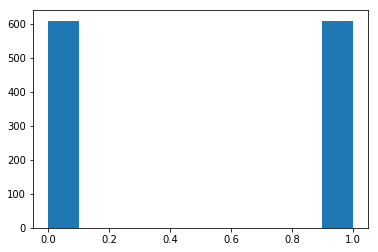

In [17]:
plt.hist(dataTrain[:,0],weights=dataTrainWeight)
print(dataTrainWeight.shape)
dataTrainWeight=dataTrainWeight.transpose()
print(dataTrainWeight.shape)
classweight = {0: 19.75,
                1: 1.}

In [18]:
traindf=pd.DataFrame(data=dataTrainSample)
normalize_df=(traindf-traindf.min())/(traindf.max()-traindf.min())
dataTrainSample1=normalize_df.values
print(dataTrainSample1)

[[1.31996402e-01 6.60093411e-01 4.02378276e-02 ... 3.03200101e-02
  9.57804374e-02 1.07001372e-01]
 [3.62692738e-02 4.77844694e-01 2.99868840e-02 ... 1.80652416e-02
  4.08252168e-02 6.54022612e-02]
 [2.48553839e-03 2.74799703e-01 2.97320145e-03 ... 3.58168695e-02
  9.31182499e-03 1.78783205e-02]
 ...
 [6.84282790e-02 6.35125450e-01 3.50516453e-02 ... 7.77089814e-02
  7.48144255e-02 7.13886522e-02]
 [2.14849402e-02 6.87603778e-01 3.04232405e-04 ... 8.59107953e-02
  3.33564160e-02 4.15494152e-02]
 [2.58004675e-01 2.46909355e-01 6.41912066e-02 ... 1.61701157e-02
  1.84886263e-01 1.94183406e-01]]


Build model

In [19]:
model = Sequential()
model.add(Dense(300, kernel_initializer="glorot_normal", activation="relu",
    input_dim=21))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid"))

# Set loss, optimizer and evaluation metrics
model.compile(
     loss="binary_crossentropy",
     #optimizer=Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
      optimizer='adam',
     metrics=["acc"])

Instructions for updating:
Colocations handled automatically by placer.


In [20]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='loss',
                              min_delta=0,
                              patience=3,
                              verbose=0, mode='auto')

In [21]:
model.save('model_HHZZ.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               6600      
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_3 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_4 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_5 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_6 (Dense)              (None, 300)               90300     
__________

2019-06-21 00:50:59.720356: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2019-06-21 00:50:59.724033: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3600000000 Hz
2019-06-21 00:50:59.724489: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x5579a2947330 executing computations on platform Host. Devices:
2019-06-21 00:50:59.724503: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>
2019-06-21 00:50:59.784280: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-06-21 00:50:59.784610: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x5579a2a9e180 executing computations on platform CUDA. Devices:
2019-06-21 00:50:59.784625: I t

In [22]:
model.fit(dataTrainSample1,dataTrainLabel,batch_size=50, epochs=30,
          sample_weight=dataTrainWeight,
          callbacks=[early_stopping])

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
85972/85972 [==============================] - 9s 106us/sample - loss: 0.4327 - acc: 0.9131
Epoch 2/30
85972/85972 [==============================] - 11s 127us/sample - loss: 0.3113 - acc: 0.9404
Epoch 3/30
85972/85972 [==============================] - 11s 129us/sample - loss: 0.2793 - acc: 0.9468
Epoch 4/30
85972/85972 [==============================] - 9s 105us/sample - loss: 0.3150 - acc: 0.9400
Epoch 5/30
85972/85972 [==============================] - 11s 127us/sample - loss: 0.2847 - acc: 0.9433
Epoch 6/30
85972/85972 [==============================] - 10s 117us/sample - loss: 0.2708 - acc: 0.9451
Epoch 7/30
85972/85972 [==============================] - 8s 93us/sample - loss: 0.3186 - acc: 0.9400
Epoch 8/30
85972/85972 [==============================] - 6s 73us/sample - loss: 0.3024 - acc: 0.9479
Epoch 9/30
85972/85972 [==============================] - 6s 65us/sample - loss: 0.2683 - acc: 0.9419
Epoch 10/30
85972/85972 

2019-06-21 00:51:07.318927: I tensorflow/stream_executor/dso_loader.cc:152] successfully opened CUDA library libcublas.so.10.0 locally


In [23]:
signaldf=pd.DataFrame(data=signalSample[:,1:])
normalize_df=(signaldf-signaldf.min())/(signaldf.max()-signaldf.min())
signalSample1=normalize_df.values
print(dataTrainSample1)
backgrounddf=pd.DataFrame(data=backgroundSample[:,1:])
normalize_df=(backgrounddf-backgrounddf.min())/(backgrounddf.max()-backgrounddf.min())
backgroundSample1=normalize_df.values
print(backgroundSample1)

[[1.31996402e-01 6.60093411e-01 4.02378276e-02 ... 3.03200101e-02
  9.57804374e-02 1.07001372e-01]
 [3.62692738e-02 4.77844694e-01 2.99868840e-02 ... 1.80652416e-02
  4.08252168e-02 6.54022612e-02]
 [2.48553839e-03 2.74799703e-01 2.97320145e-03 ... 3.58168695e-02
  9.31182499e-03 1.78783205e-02]
 ...
 [6.84282790e-02 6.35125450e-01 3.50516453e-02 ... 7.77089814e-02
  7.48144255e-02 7.13886522e-02]
 [2.14849402e-02 6.87603778e-01 3.04232405e-04 ... 8.59107953e-02
  3.33564160e-02 4.15494152e-02]
 [2.58004675e-01 2.46909355e-01 6.41912066e-02 ... 1.61701157e-02
  1.84886263e-01 1.94183406e-01]]
[[0.1048238  0.50330782 0.08915562 ... 0.0885143  0.09467147 0.07783742]
 [0.19377055 0.29564217 0.24111472 ... 0.3229771  0.30668546 0.2640282 ]
 [0.04893508 0.73308935 0.04601364 ... 0.19212414 0.05945254 0.06798196]
 ...
 [0.13033736 0.76843606 0.00194335 ... 0.03767111 0.22142912 0.16110338]
 [0.0810195  0.34781338 0.04074328 ... 0.05596303 0.1327359  0.10465274]
 [0.09606173 0.32056755 0.1405

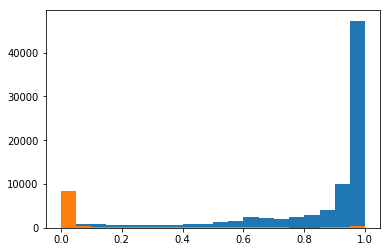

In [24]:
signalNN=model.predict(signalSample1)
backgroundNN=model.predict(backgroundSample1)
plt.hist(signalNN,bins=20)
plt.hist(backgroundNN,bins=20)
NNTrainScore=model.predict(dataTrainSample1)

(array([8434.,  331.,  216.,  152.,  107.,  103.,   98.,   87.,   97.,
          94.,  112.,  149.,  148.,   99.,   82.,   57.,   67.,   74.,
         130.,  358.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
       dtype=float32),
 <a list of 20 Patch objects>)

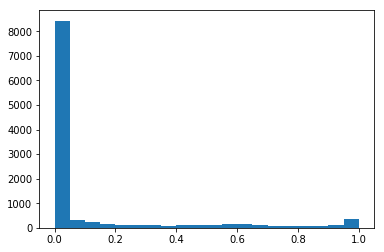

In [25]:
backgroundNN=model.predict(backgroundSample1)
plt.hist(backgroundNN,bins=20)

Save NN model to h5 file

In [26]:
model.save('model_HHWW.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               6600      
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_3 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_4 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_5 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_6 (Dense)              (None, 300)               90300     
__________

In [29]:
signalNNScore=model.predict(signalSample1)
#backgroundNNScore=model.predict(backgroundArray[:,1:])
print(signalNNScore)

[[1.        ]
 [0.8093015 ]
 [0.7421476 ]
 ...
 [0.9796284 ]
 [0.97829205]
 [0.9595048 ]]


(array([ 1127.,   875.,   776.,   707.,   667.,   629.,   667.,   736.,
          846.,   927.,  1308.,  1651.,  2539.,  2251.,  2006.,  2567.,
         2899.,  4168.,  9891., 47294.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
       dtype=float32),
 <a list of 20 Patch objects>)

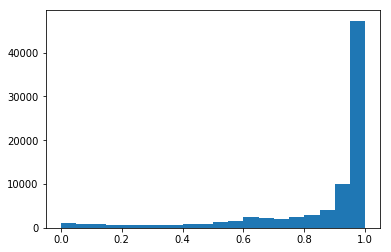

In [30]:
plt.hist(signalNNScore,bins=20)

In [31]:
cuda.select_device(0)
cuda.close()

In [32]:
varName=["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"]
BDTtrain=xgb.DMatrix(dataTrainSample,label=dataTrainLabel,weight=dataTrainWeight,feature_names=varName)
BDTtest=xgb.DMatrix(dataTestSample,label=dataTestLabel,weight=dataTestWeight,feature_names=varName)
BDTSignal=xgb.DMatrix(signalArray[:,1:],feature_names=varName)
BDTBackground=xgb.DMatrix(backgroundArray[:,1:],feature_names=varName)
param = {'max_depth': 7, 'eta': 0.6, 'silent': 1, 'objective': 'binary:logistic'}
param['nthread'] = 16
param['eval_metric'] = 'auc'
param['tree_method'] = 'gpu_hist'
param['grow_policy'] = 'depthwise'
param['subsample']=0.9
evallist = [(BDTtest, 'eval'), (BDTtrain, 'train')]

/home/shuzhou/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
/home/shuzhou/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
/home/shuzhou/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
/home/shuzhou/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndar

In [33]:
num_round = 1000
GBDT = xgb.train(param, BDTtrain, num_round, evallist)

[0]	eval-auc:0.952679	train-auc:0.962293
[1]	eval-auc:0.961473	train-auc:0.971932
[2]	eval-auc:0.968422	train-auc:0.977943
[3]	eval-auc:0.971262	train-auc:0.980605
[4]	eval-auc:0.973617	train-auc:0.98216
[5]	eval-auc:0.976202	train-auc:0.983552
[6]	eval-auc:0.976688	train-auc:0.985102
[7]	eval-auc:0.977167	train-auc:0.986154
[8]	eval-auc:0.978351	train-auc:0.986929
[9]	eval-auc:0.978186	train-auc:0.987862
[10]	eval-auc:0.978392	train-auc:0.988529
[11]	eval-auc:0.977569	train-auc:0.989202
[12]	eval-auc:0.977665	train-auc:0.990198
[13]	eval-auc:0.977182	train-auc:0.991066
[14]	eval-auc:0.977025	train-auc:0.991631
[15]	eval-auc:0.976819	train-auc:0.992399
[16]	eval-auc:0.976311	train-auc:0.993052
[17]	eval-auc:0.97639	train-auc:0.9936
[18]	eval-auc:0.976348	train-auc:0.994257
[19]	eval-auc:0.977086	train-auc:0.99477
[20]	eval-auc:0.97712	train-auc:0.995302
[21]	eval-auc:0.976807	train-auc:0.995675
[22]	eval-auc:0.97661	train-auc:0.99594
[23]	eval-auc:0.97662	train-auc:0.996453
[24]	eval-a

[199]	eval-auc:0.969144	train-auc:1.01904
[200]	eval-auc:0.968851	train-auc:1.01907
[201]	eval-auc:0.969041	train-auc:1.0191
[202]	eval-auc:0.968571	train-auc:1.01919
[203]	eval-auc:0.968446	train-auc:1.01918
[204]	eval-auc:0.968104	train-auc:1.01932
[205]	eval-auc:0.968272	train-auc:1.01946
[206]	eval-auc:0.968199	train-auc:1.01949
[207]	eval-auc:0.968073	train-auc:1.01955
[208]	eval-auc:0.968169	train-auc:1.01958
[209]	eval-auc:0.967807	train-auc:1.01968
[210]	eval-auc:0.967555	train-auc:1.01975
[211]	eval-auc:0.967587	train-auc:1.01983
[212]	eval-auc:0.967399	train-auc:1.01989
[213]	eval-auc:0.967397	train-auc:1.01998
[214]	eval-auc:0.96739	train-auc:1.02007
[215]	eval-auc:0.966837	train-auc:1.02012
[216]	eval-auc:0.966945	train-auc:1.02016
[217]	eval-auc:0.967143	train-auc:1.0203
[218]	eval-auc:0.966938	train-auc:1.02046
[219]	eval-auc:0.966915	train-auc:1.02055
[220]	eval-auc:0.966738	train-auc:1.02072
[221]	eval-auc:0.966386	train-auc:1.02083
[222]	eval-auc:0.966725	train-auc:1.0

[396]	eval-auc:0.956568	train-auc:1.02788
[397]	eval-auc:0.956032	train-auc:1.028
[398]	eval-auc:0.955051	train-auc:1.02789
[399]	eval-auc:0.955046	train-auc:1.02791
[400]	eval-auc:0.955735	train-auc:1.02786
[401]	eval-auc:0.955777	train-auc:1.02793
[402]	eval-auc:0.956256	train-auc:1.02793
[403]	eval-auc:0.95671	train-auc:1.02802
[404]	eval-auc:0.956701	train-auc:1.02805
[405]	eval-auc:0.95694	train-auc:1.02804
[406]	eval-auc:0.956898	train-auc:1.02811
[407]	eval-auc:0.956666	train-auc:1.02821
[408]	eval-auc:0.956208	train-auc:1.02818
[409]	eval-auc:0.956364	train-auc:1.02826
[410]	eval-auc:0.956169	train-auc:1.02827
[411]	eval-auc:0.956109	train-auc:1.02829
[412]	eval-auc:0.956223	train-auc:1.02839
[413]	eval-auc:0.956426	train-auc:1.02847
[414]	eval-auc:0.95636	train-auc:1.02848
[415]	eval-auc:0.956903	train-auc:1.02841
[416]	eval-auc:0.957132	train-auc:1.02854
[417]	eval-auc:0.956888	train-auc:1.02857
[418]	eval-auc:0.956703	train-auc:1.0285
[419]	eval-auc:0.95669	train-auc:1.02851

[593]	eval-auc:0.949264	train-auc:1.03124
[594]	eval-auc:0.949701	train-auc:1.03124
[595]	eval-auc:0.950164	train-auc:1.0313
[596]	eval-auc:0.949873	train-auc:1.03134
[597]	eval-auc:0.950093	train-auc:1.03141
[598]	eval-auc:0.95013	train-auc:1.03149
[599]	eval-auc:0.949797	train-auc:1.03149
[600]	eval-auc:0.949446	train-auc:1.03147
[601]	eval-auc:0.949684	train-auc:1.0315
[602]	eval-auc:0.949487	train-auc:1.03148
[603]	eval-auc:0.948894	train-auc:1.03144
[604]	eval-auc:0.948944	train-auc:1.03146
[605]	eval-auc:0.94899	train-auc:1.03143
[606]	eval-auc:0.949058	train-auc:1.0314
[607]	eval-auc:0.948853	train-auc:1.03144
[608]	eval-auc:0.948422	train-auc:1.03139
[609]	eval-auc:0.948323	train-auc:1.03142
[610]	eval-auc:0.948118	train-auc:1.03143
[611]	eval-auc:0.948334	train-auc:1.03144
[612]	eval-auc:0.948165	train-auc:1.03154
[613]	eval-auc:0.948306	train-auc:1.03151
[614]	eval-auc:0.9485	train-auc:1.03152
[615]	eval-auc:0.94857	train-auc:1.03154
[616]	eval-auc:0.948213	train-auc:1.03156


[790]	eval-auc:0.944801	train-auc:1.03264
[791]	eval-auc:0.944282	train-auc:1.03261
[792]	eval-auc:0.943825	train-auc:1.0326
[793]	eval-auc:0.94448	train-auc:1.03261
[794]	eval-auc:0.944539	train-auc:1.0326
[795]	eval-auc:0.943638	train-auc:1.03265
[796]	eval-auc:0.943198	train-auc:1.03257
[797]	eval-auc:0.943967	train-auc:1.03259
[798]	eval-auc:0.94435	train-auc:1.03262
[799]	eval-auc:0.944337	train-auc:1.03264
[800]	eval-auc:0.944153	train-auc:1.03263
[801]	eval-auc:0.944376	train-auc:1.03267
[802]	eval-auc:0.944382	train-auc:1.03269
[803]	eval-auc:0.944144	train-auc:1.03262
[804]	eval-auc:0.943748	train-auc:1.03265
[805]	eval-auc:0.943721	train-auc:1.03266
[806]	eval-auc:0.943621	train-auc:1.03272
[807]	eval-auc:0.943995	train-auc:1.03277
[808]	eval-auc:0.94434	train-auc:1.03276
[809]	eval-auc:0.943969	train-auc:1.03272
[810]	eval-auc:0.943927	train-auc:1.03271
[811]	eval-auc:0.943811	train-auc:1.03279
[812]	eval-auc:0.943853	train-auc:1.03281
[813]	eval-auc:0.944052	train-auc:1.032

[987]	eval-auc:0.938148	train-auc:1.0336
[988]	eval-auc:0.939334	train-auc:1.03363
[989]	eval-auc:0.939517	train-auc:1.03364
[990]	eval-auc:0.939413	train-auc:1.03354
[991]	eval-auc:0.938784	train-auc:1.03346
[992]	eval-auc:0.9383	train-auc:1.03346
[993]	eval-auc:0.938727	train-auc:1.03347
[994]	eval-auc:0.938381	train-auc:1.03353
[995]	eval-auc:0.938368	train-auc:1.03356
[996]	eval-auc:0.938173	train-auc:1.03361
[997]	eval-auc:0.938287	train-auc:1.03361
[998]	eval-auc:0.938159	train-auc:1.03356
[999]	eval-auc:0.938943	train-auc:1.03354


<Figure size 1440x1440 with 0 Axes>

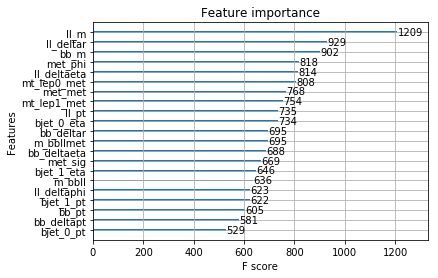

In [34]:
plt.figure(figsize=(20,20))
xgb.plot_importance(GBDT)
plt.show()

(array([9819.,  196.,  129.,   86.,   51.,   47.,   59.,   39.,   36.,
          28.,   30.,   29.,   37.,   31.,   31.,   31.,   29.,   34.,
          28.,  225.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
       dtype=float32),
 <a list of 20 Patch objects>)

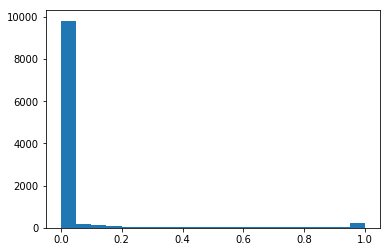

In [35]:
SignalScore=GBDT.predict(BDTSignal)
#plt.hist(SignalScore,bins=20)
BackgroundScore=GBDT.predict(BDTBackground)
plt.hist(BackgroundScore,bins=20)

(array([ 1952.,   186.,   161.,   115.,   114.,   108.,   105.,   115.,
          114.,   135.,   135.,   148.,   133.,   179.,   172.,   197.,
          237.,   317.,   507., 79401.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
       dtype=float32),
 <a list of 20 Patch objects>)

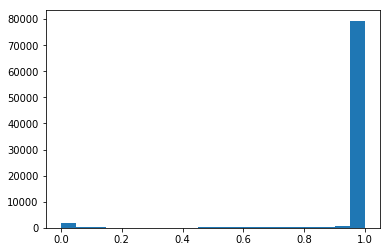

In [36]:
plt.hist(SignalScore,bins=20)

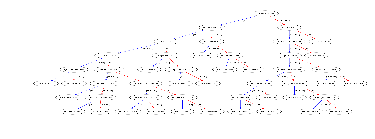

In [37]:
plot_tree(GBDT, num_trees=4)

(array([10506.,   347.,   258.,   183.,   149.,   140.,   155.,   138.,
          140.,   152.,   157.,   164.,   160.,   198.,   182.,   211.,
          246.,   328.,   499., 71659.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
       dtype=float32),
 <a list of 20 Patch objects>)

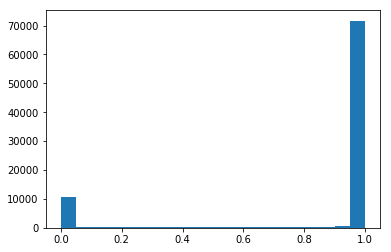

In [38]:
trainScore=GBDT.predict(BDTtrain)
testScore=GBDT.predict(BDTtest)
plt.hist(trainScore,bins=20)

In [39]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTrainLabel,trainScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)

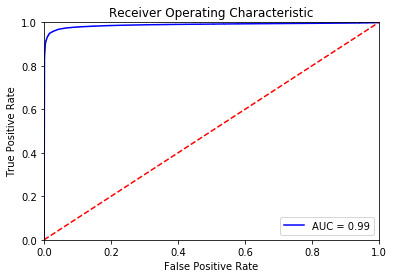

In [40]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

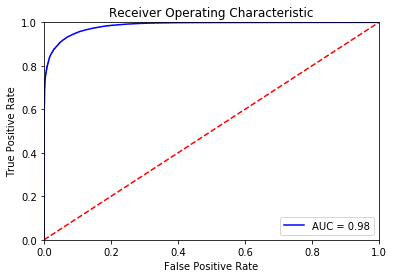

In [41]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTrainLabel,NNTrainScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
pickle.dump(GBDT, open("GBDT_HHww.pickle.dat", "wb"))

In [ ]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTestLabel,testScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()